# <center> Supervised learning. Regression
## <center> Predicting US Citizens' Individual Medical Expenses Paid by Health Insurance

In [489]:
# import libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn import linear_model 
from sklearn import metrics 
from sklearn import preprocessing
from sklearn import model_selection
import sklearn

In [490]:
original_data = pd.read_csv('C:/Users/atade/OneDrive/Рабочий стол/Learning/Machine_Learning/HW_ML_2/insurance.csv')
data = original_data.copy()

How the process of developing DS projects is organized according to the CRISP-DM methodology.

Stages of the CRISP-DM model:
1. Requirements analysis
2. Data exploration
3. Data preparation
4. Simulation
5. Model evaluation
6. Introduction

### Requirements analysis

We will build an ML model that predicts the individual medical expenses of US citizens paid by health insurance.

**Getting to know the data**

In [491]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


So the dataset contains the following columns:

1. age — age of the main beneficiary;
2. sex is the gender of the insurance contractor;
3. bmi - body mass index (kgm), ideally - from 18.5 to 24.9;
4. children — the number of children covered by health insurance;
5. smoker - whether the person is a smoker;
6. region - US residential area (northeast, southeast, northwest, southwest);
7. charges (target attribute) - individual medical expenses paid by health insurance.

# <center> Work with data for model creation


We must come to the conclusion whether the problem is solvable. Whether the model can get the baseline. To do this, we conduct a small study of the data, basic pre-processing and build a simple model, without selecting parameters.

### Data exploration

In [492]:
display(data.describe(), data.shape)

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


(1338, 7)

In [493]:
display(data.describe(include='object'))

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [494]:
types = data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age', 'bmi', 'children', 'charges']

For each numeric feature, we construct a histogram of features and a scatterplot illustrating the dependence of the target feature on each of the factors. Additionally, we construct a linear regression equation on top of the scatterplot.

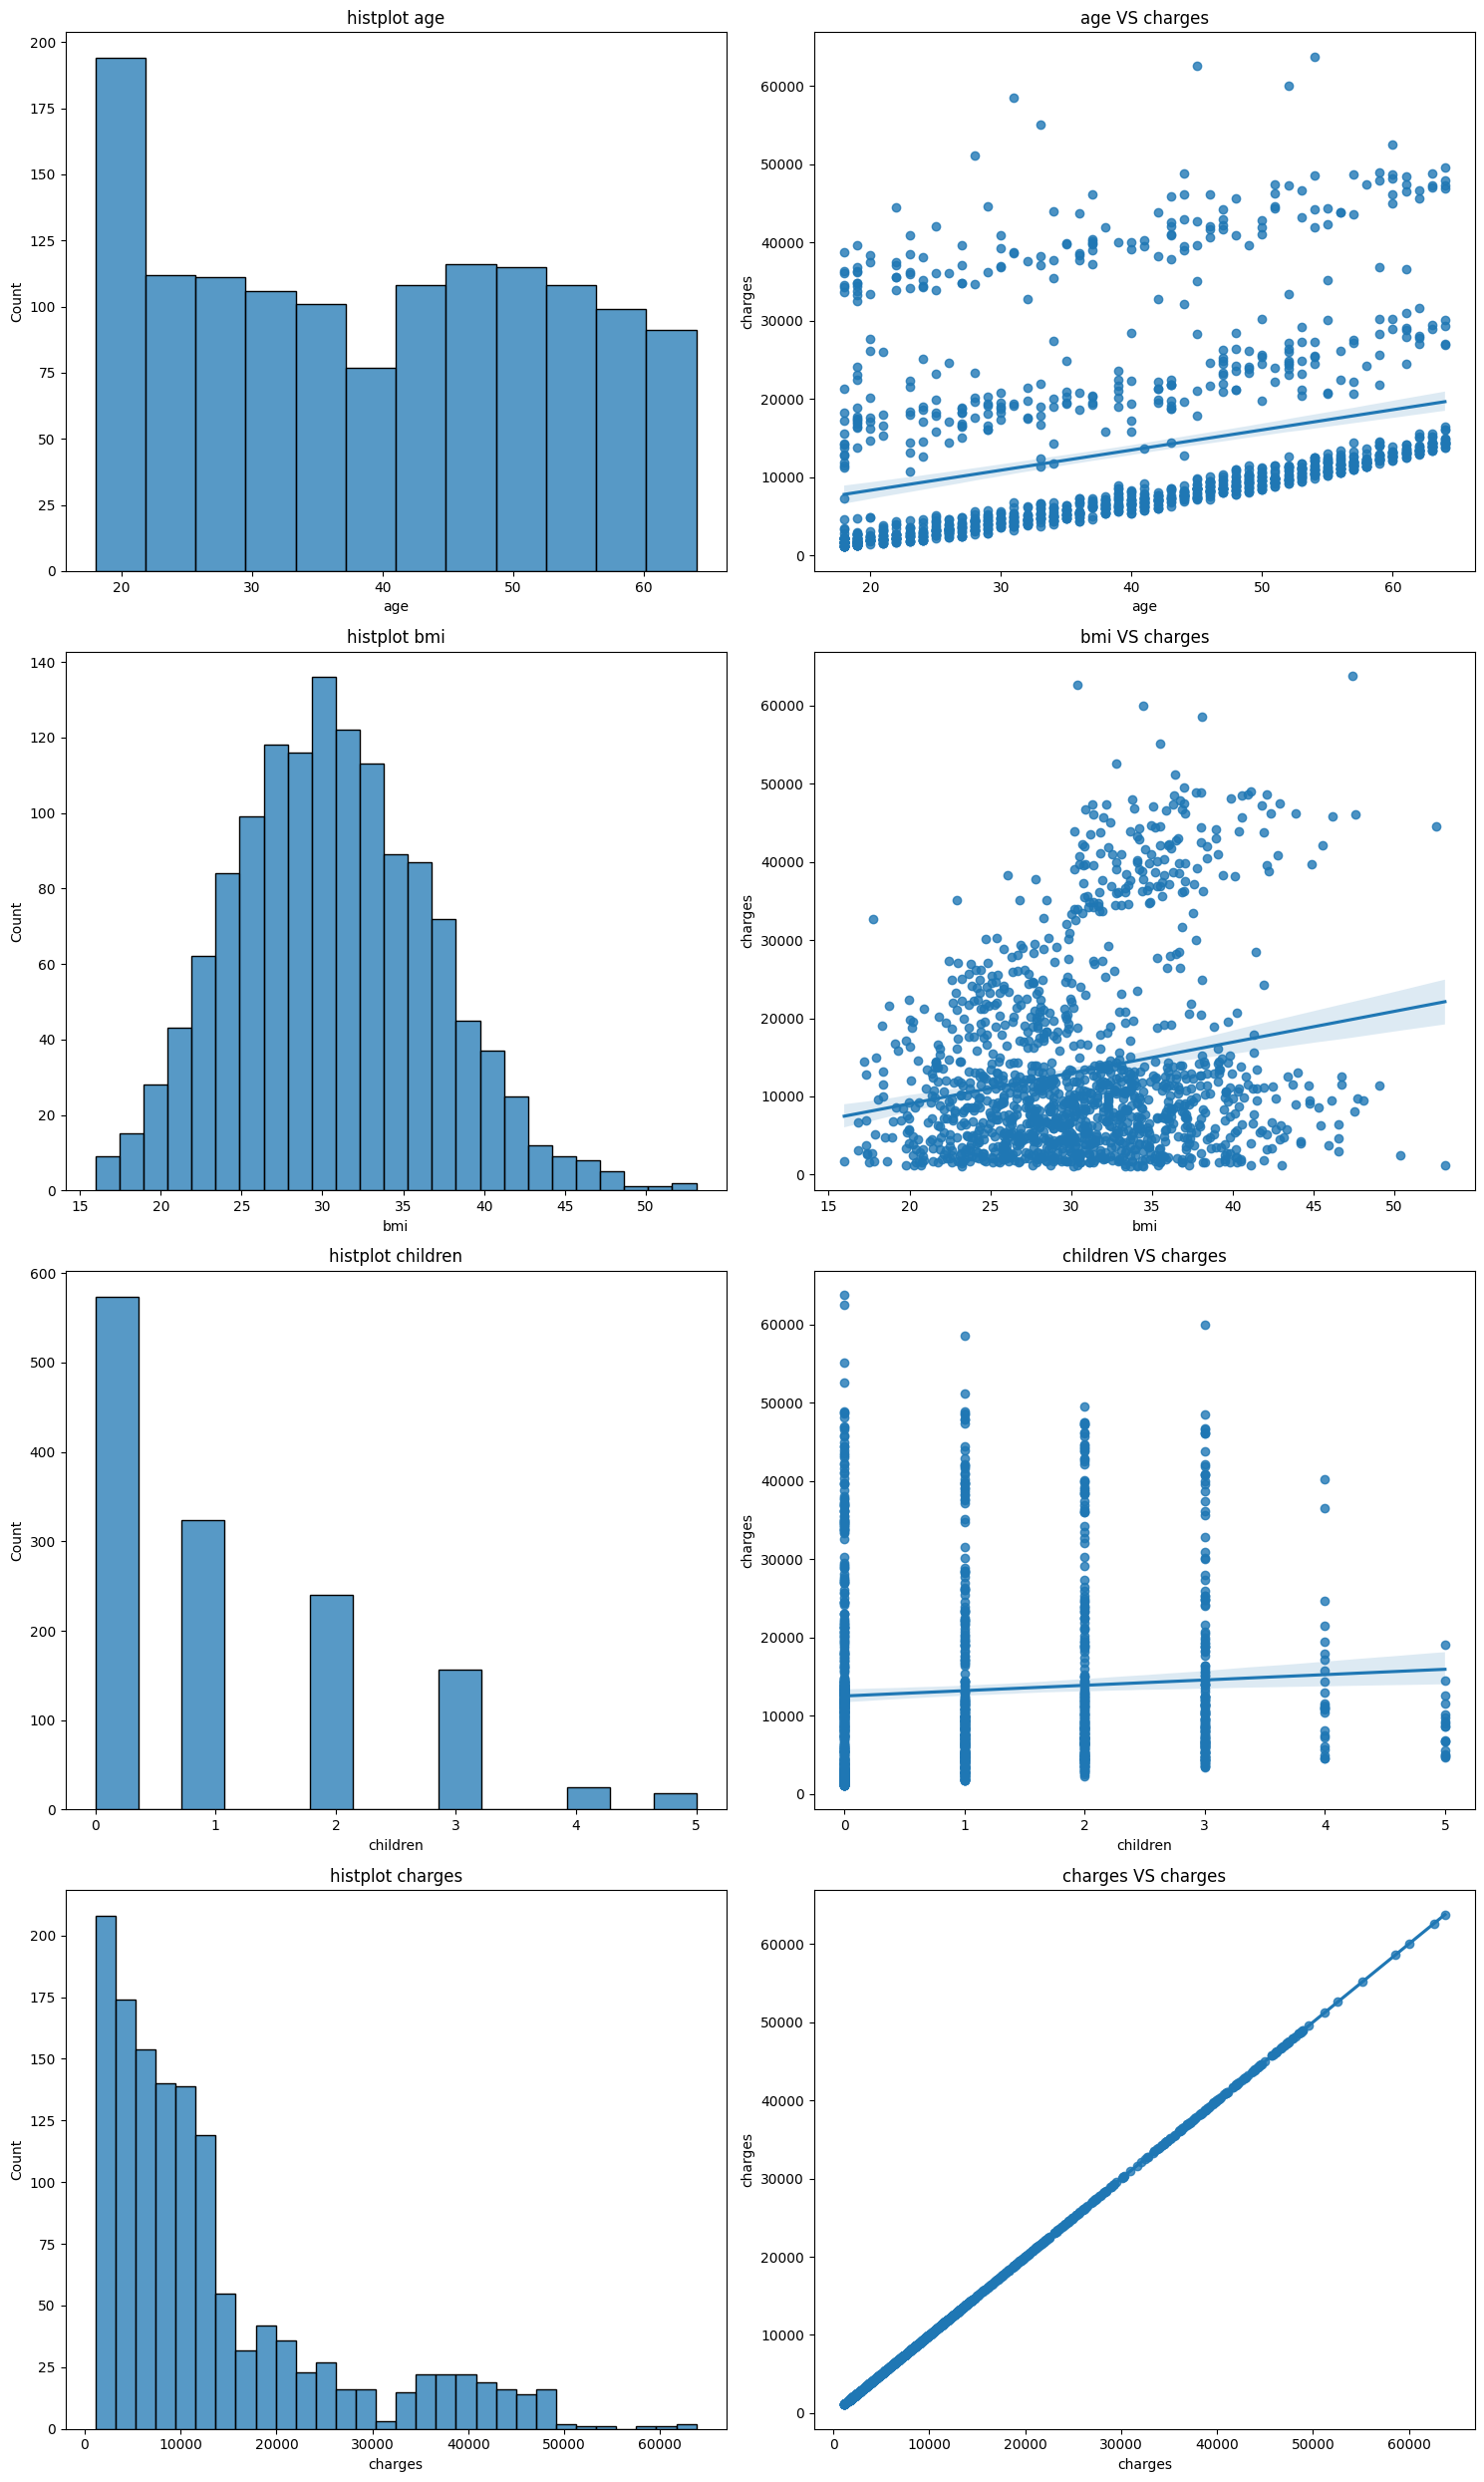

In [495]:
fig, axes = plt.subplots(len(num_features), 2, figsize=(15,25))

for i, feature in enumerate(num_features):

    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    histplot.set_title('histplot {}'.format(feature))

    regplot = sns.regplot(data=data, x=feature, y='charges', ax=axes[i][1])
    regplot.set_title('{} VS charges'.format(feature))
plt.tight_layout()
plt.show()

### Data preparation

We will code according to the following principle:

1. smoker - convert to binary values (0 - non-smoker, 1 - smoker);
2. sex - similar (0 - female, 1 - male);
3. region - use OneHot encoding (use the get_dummies function).

In [496]:
data['smoker'] = data['smoker'].apply(lambda x: 0 if x=='no' else 1)
data['sex'] = data['sex'].apply(lambda x: 1 if x=='male' else 0)

data = pd.get_dummies(data=data, columns=['region'])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1338 non-null   int64  
 1   sex               1338 non-null   int64  
 2   bmi               1338 non-null   float64
 3   children          1338 non-null   int64  
 4   smoker            1338 non-null   int64  
 5   charges           1338 non-null   float64
 6   region_northeast  1338 non-null   bool   
 7   region_northwest  1338 non-null   bool   
 8   region_southeast  1338 non-null   bool   
 9   region_southwest  1338 non-null   bool   
dtypes: bool(4), float64(2), int64(4)
memory usage: 68.1 KB


We build a heat map for the correlation matrix in order to evaluate the multicollinear dependence and the linear relationship between the factors and the target feature (price)

<AxesSubplot: >

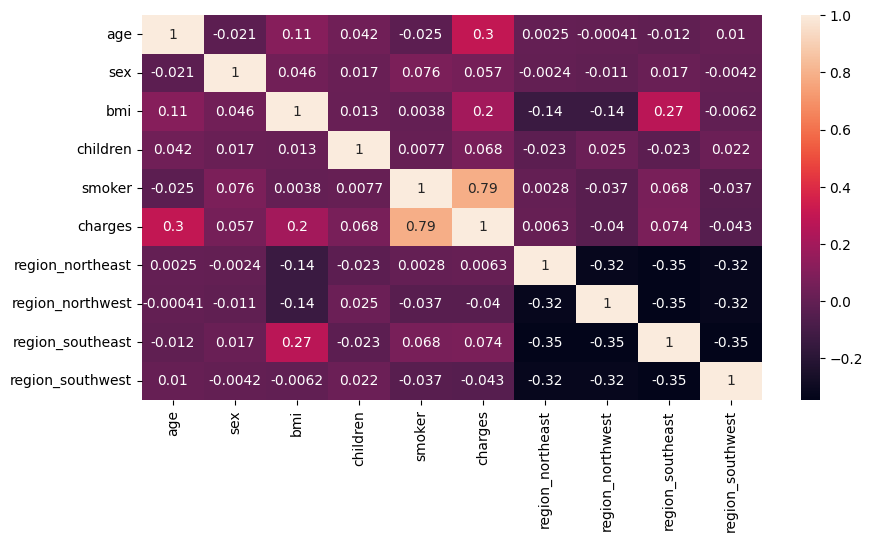

In [497]:
fig = plt.figure(figsize=(10,5))
sns.heatmap(data.corr(), annot=True)


Divide the data set into a matrix of observations X (a table of objects and their features) and a column of correct answers y

In [498]:
X = data.drop(columns=['charges'])
y = data['charges']

We divide the entire sample into training and test in the ratio 80/20.

On the training set, we will train the models, and on the test set, we will check their quality.

In [499]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=42, test_size=0.2)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


### Simulation + Model Evaluation

The purpose of the stage is to build a model that solves the problem and evaluate its quality.

Let's create a function in advance that will calculate the metrics:

1. MAE - mean absolute error (target metric)
2. MAPE - mean absolute error in percent
3. $R^2$ - coefficient of determination

In [500]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

**Linear regression model:**

The linear regression model has the following form:
$$\widehat{y_i}= w_0+\sum_{j=0}^m w_j x_{ij}$$
where $x_{ij}$ is an object from the $i$-th row and $j$-th column from the table of objects-attribute $X$, $y_i$ is the correct answer corresponding to $x_{i}$, $\omega $ — linear regression parameters

To search for model parameters, an empirical risk minimization scheme is used - such parameters $\omega$ are searched for, for which the error function $L(\omega)$ would be minimal.

As a loss function, we use MSE - the mean square of the error.

$$L(\omega) = MSE = \frac{1}{n} * \sum_{i=1}^{n}{(y_i - \widehat{y_i})^2} \Rightarrow min_\omega $$

**Analytical solution: least squares (OLS):**

$$\omega=(X^TX)^{-1}X^Ty$$

In [501]:
lr = linear_model.LinearRegression()
lr = lr.fit(X=X_train, y=y_train)

y_test_predict = lr.predict(X=X_test)
y_train_predict = lr.predict(X=X_train)

print_metrics(
    y_test_predict=y_test_predict,
    y_train_predict= y_train_predict,
    y_train=y_train,
    y_test=y_test)


# another function for beautiful output
def print_coef(lr_coef, n=50):
    count = 0
    for i, coef in enumerate((lr_coef)):

        count +=1
        print('w{}: {:.2f}'.format(i, coef))

        if i == n:
            break
    

print_coef(lr.coef_)

Train R^2: 0.742
Train MAE: 4208.235
Train MAPE: 42.203


Test R^2: 0.784
Test MAE: 4181.194
Train MAPE: 46.888
w0: 256.98
w1: -18.59
w2: 337.09
w3: 425.28
w4: 23651.13
w5: 459.59
w6: 88.91
w7: -198.28
w8: -350.21


Let's build a boxplot diagram to visualize the errors of the linear regression model on the training and test sets.

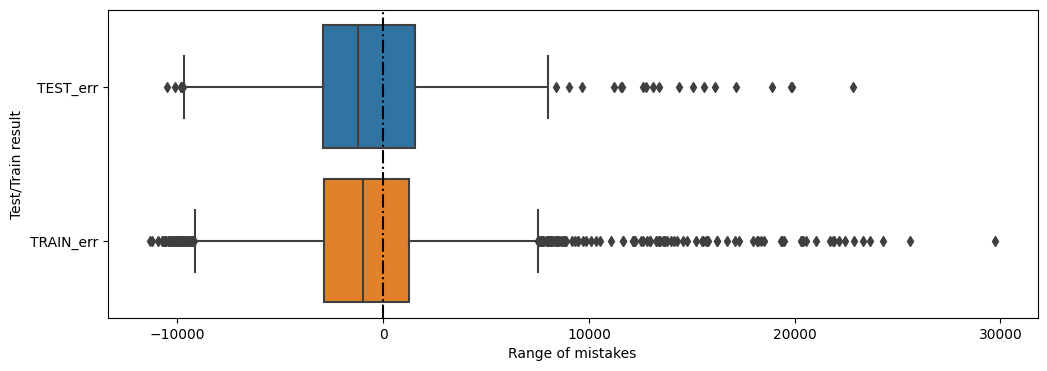

In [502]:
fig, axes = plt.subplots(1,1,figsize=(12,4))

pred_test_error = y_test-lr.predict(X_test)
pred_train_error = y_train - lr.predict(X_train) 


data_errors = pd.DataFrame({ 'TEST_err': pred_test_error, 'TRAIN_err' : pred_train_error})

sns.boxplot(
    data=data_errors,
    orient='h',
    ax=axes
)

axes.axvline(x=0, color='k', ls='-.')
axes.set_ylabel('Test/Train result')
axes.set_xlabel('Range of mistakes')
plt.show()

As we can see on the graph, the model can produce a fairly large error spread.
#


Let's try to normalize the data and generate a polynomial feature in 2 degree.

In [507]:
minmax = preprocessing.MinMaxScaler()
poly = preprocessing.PolynomialFeatures(include_bias=False, degree=2) # Don't add column with 1 - that already there


minmax.fit(X_train)
X_train_scaled = minmax.transform(X_train)
X_test_scaled = minmax.transform(X_test)



poly.fit(X_train_scaled)
X_train_poly = poly.transform(X=X_train_scaled)
X_test_poly = poly.transform(X=X_test_scaled)

X_test_poly.shape # (268, 54)

lr_polynom = linear_model.LinearRegression()
lr_polynom = lr_polynom.fit(X_train_poly, y_train)


y_test_polynom = lr_polynom.predict(X_test_poly)
y_train_polynom = lr_polynom.predict(X_train_poly)

print_metrics(y_train=y_train, y_train_predict=y_train_polynom, y_test=y_test, y_test_predict=y_test_polynom)
print(' ')
print_coef(lr_polynom.coef_, n=15)

Train R^2: 0.842
Train MAE: 2909.271
Train MAPE: 29.902


Test R^2: 0.866
Test MAE: 2749.662
Train MAPE: 30.719
 
w0: -1255359644811768.75
w1: 8220861424883252.00
w2: -23873941308943608.00
w3: 18319544196201020.00
w4: 8009998652423517.00
w5: -47937130689769352.00
w6: -82963535055535808.00
w7: -32854168178563672.00
w8: -33560289224139564.00
w9: 8534.25
w10: 906.38
w11: 890.38
w12: -1699.56
w13: 158.56
w14: 1255359644813593.25
w15: 1255359644814657.25


 Huge coefficients for the parameters is a sign of model overfitting, which can be bad for the quality of the model. *Due to its complexity (the number of factors), the model fully adapted to the training data, but in return received a high variance in performance on data that it had not seen before*.
#
Solving the problem of huge coefficient values - using regularization

#### Method Lasso :
$$
L(\omega) = \text{MSE} + \alpha \sum_{j=1}^{m} |\omega_j|
$$


In [504]:
lasso_lr_poly = linear_model.Lasso(max_iter=2000)
lasso_lr_poly.fit(X_train_poly, y_train)

y_train_predict_lasso = lasso_lr_poly.predict(X_train_poly)
y_test_predict_lasso = lasso_lr_poly.predict(X_test_poly)

print_metrics(y_test_predict=y_test_predict_lasso,
              y_test=y_test,
              y_train_predict=y_train_predict_lasso,
              y_train=y_train)


Train R^2: 0.842
Train MAE: 2890.473
Train MAPE: 29.401


Test R^2: 0.867
Test MAE: 2719.334
Train MAPE: 30.070


#### Method Ridge

$$L(\omega) = MSE + \alpha \sum_{j=1}^{m}{\omega_j^2}$$

In [505]:
lasso_lr_poly = linear_model.Ridge()
lasso_lr_poly.fit(X_train_poly, y_train)

y_train_predict_lasso = lasso_lr_poly.predict(X_train_poly)
y_test_predict_lasso = lasso_lr_poly.predict(X_test_poly)

print_metrics(y_test_predict=y_test_predict_lasso,
              y_test=y_test,
              y_train_predict=y_train_predict_lasso,
              y_train=y_train)


Train R^2: 0.839
Train MAE: 2948.804
Train MAPE: 29.546


Test R^2: 0.863
Test MAE: 2860.555
Train MAPE: 31.380


In this project, we attempted to train a linear regression model to predict numerical values based on a limited dataset of only 1338 instances. However, due to the small size of the dataset, we faced limitations in achieving the expected results.

The scarcity of data can hinder the model's ability to capture the underlying patterns and relationships effectively. With a larger dataset, the model would have had more instances to learn from and potentially better generalize to unseen data.

Additionally, a small dataset can lead to overfitting, where the model becomes too specific to the training data and fails to generalize well to new observations. This can result in poor performance when making predictions on real-world data.

Furthermore, the limited data may not adequately represent the diversity and complexity of the problem domain, leading to biased or incomplete learning. A more comprehensive dataset would provide a broader range of scenarios and enable the model to learn a more robust representation of the underlying relationships.

In conclusion, the limitations imposed by the small dataset size hindered our ability to achieve the desired results. To improve the performance and reliability of the model, acquiring a larger and more diverse dataset would be beneficial. This would enable the model to learn more effectively and make more accurate predictions in real-world scenarios.

